In [142]:
import nidaqmx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

#para saber el ID de la placa conectada (DevX)
system = nidaqmx.system.System.local()
for device in system.devices:
    print(device)

Device(name=Dev2)


In [145]:
# para setear (y preguntar) el modo y rango de un canal analógico
with nidaqmx.Task() as task:
    ai_channel = task.ai_channels.add_ai_voltage_chan("Dev2/ai1",
                                                         max_val=10, min_val=-10
                                                         )
    print(ai_channel.ai_term_cfg)    
    print(ai_channel.ai_max)
    print(ai_channel.ai_min)	

TerminalConfiguration.DIFF
10.0
-10.0


In [192]:
# Medicion por tiempo/samples de una sola vez
def medicion_una_vez(duracion, fs, dev_ch='Dev2/ai1'):

    cant_puntos = int(duracion * fs)
    with nidaqmx.Task() as task:
        modo = nidaqmx.constants.TerminalConfiguration.DIFF
        task.ai_channels.add_ai_voltage_chan(dev_ch, terminal_config=modo,
                                             units=nidaqmx.constants.VoltageUnits.VOLTS,
                                             min_val=-150e-3, max_val=50e-3,
                                            #min_val = -10, max_val= 10,
                                             )

        task.timing.cfg_samp_clk_timing(fs,
                                        samps_per_chan=cant_puntos,
                                        sample_mode=nidaqmx.constants.AcquisitionType.FINITE)

        data = task.read(number_of_samples_per_channel=nidaqmx.constants.READ_ALL_AVAILABLE)
    data = np.asarray(data)
    return data


# duracion = 1 #segundos
# fs = 1000 #Frecuencia de muestreo
# y = medicion_una_vez(duracion, fs)
# t = np.linspace(0,.999,1000)
# plt.plot(t,y)
# plt.grid()
# plt.show()

In [ ]:
per_muestreo = 4e-6  # s
frec_muestreo = 1/per_muestreo  # Hz
duracion = 10  # s
cant_datos = duracion*frec_muestreo
tiempo = np.arange(0, duracion - per_muestreo/2, 1 / frec_muestreo)
print(frec_muestreo)
start = time.time()
v = medicion_una_vez(duracion,  # s
                     frec_muestreo,  # s^-1
                     )
stop = time.time()
print(stop - start)
print(cant_datos, len(v))

plt.plot(tiempo*1e3, v*1e3)
plt.xlabel(f'Tiempo [ms]')
plt.ylabel(f'Voltaje [mV]')
plt.show()

In [ ]:
tension = 1050
config = 'a'
modo = 'sample'
angulo = 230
np.save(f"DAQ_10s_50_-150/{modo}_f{frec_muestreo*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy", np.array([tiempo, v]))

loaded a
ploted bar
loaded b
ploted bar
loaded c
ploted bar
loaded d
ploted bar


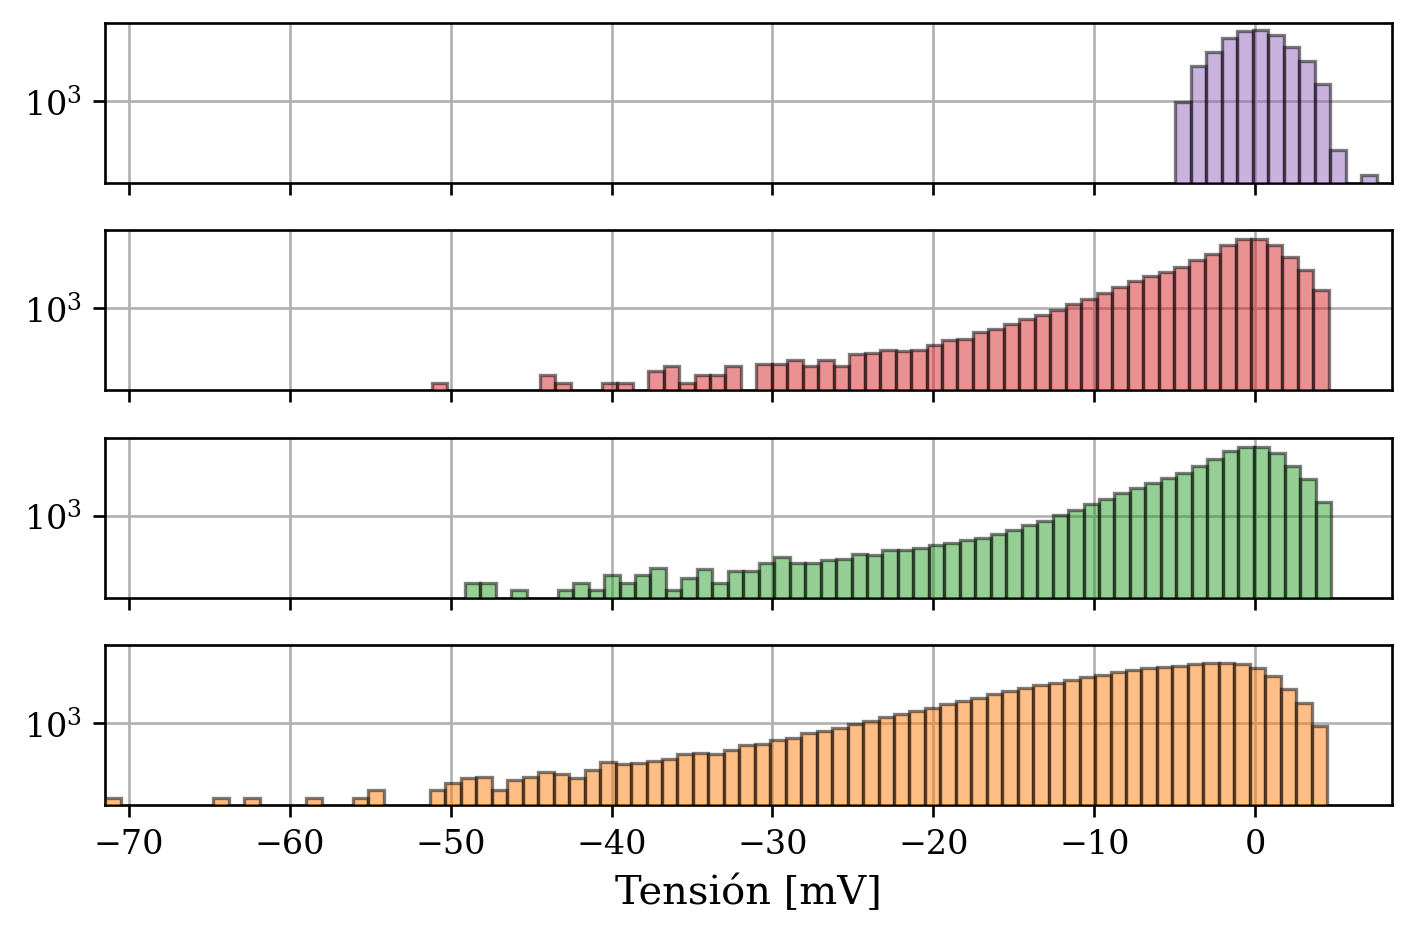

In [212]:
modo = "sample"
angulo = 230  # °
tension = 1050  # V
frec_muestreo = 250e3  # Hz
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, tight_layout=True)
fig.subplots_adjust(hspace=0)
color_id = 4
height_dict = dict()
tension_dict = dict()
for config, ax in zip(["a", "b", "c", "d"], axs):
    tiempo, volt_vals = np.load(f"DAQ_10s_50_-150/{modo}_f{frec_muestreo*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  # s, V
    print(f"loaded {config}")
    max_val = 300e-3  # V
    min_val = -300e-3  # V
    res = 1.05*(max_val - (min_val))/(2**16)  # V
    # res = 4e-3  # Escala en 100 mV
    vals_unicos = np.unique(volt_vals,)
    bin_edges = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, 100*res)  # V
    count, bin_edges = np.histogram(volt_vals, bin_edges, )
    bin_center = np.arange(vals_unicos.min(), vals_unicos.max(), 100*res)  # V
    bar_height = count  # /count.max()
    try:
        ax.bar(x=bin_center*1e3, height=bar_height, width=res*1e3,
                    color=f"C{color_id}", zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
    except ValueError:
        bin_center = np.arange(vals_unicos.min(), vals_unicos.max()+res/2, 100*res)  # V
        bar_height = count  # /count.max()
        ax.bar(x=bin_center[:-1]*1e3, height=bar_height, width=100*res*1e3,
                    color=f"C{color_id}", zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
    print("ploted bar")
    # sns.rugplot(x=volt_vals*1e3, c="k", height=0.07, alpha=0.1, lw=1.5, ax=ax, zorder=11)
    # print("ploted rug")
    color_id -= 1
    height_dict[config] = bar_height
    tension_dict[config] = bin_center

    ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")


plt.show()